In [10]:
import sys
import pandas as pd
import numpy as np
from matplotlib import pyplot as plt
from sklearn.model_selection import KFold
from scipy.stats import ttest_1samp
%matplotlib inline

if '..' not in sys.path:
    sys.path.append('..')
import make_bayes_submission

In [2]:
valid_pred = pd.read_hdf('../../_data/20170718-003045-b2-albu-eval.h5')
valid_pred[:3]

,agriculture,artisinal_mine,bare_ground,blooming,blow_down,clear,cloudy,conventional_mine,cultivation,habitation,haze,partly_cloudy,primary,road,selective_logging,slash_burn,water
b'image_name',,,,,,,,,,,,,,,,,
train_0,0.002900,0.001370,0.001533,0.001599,0.001442,0.733193,0.001396,0.001365,0.002094,0.001792,0.828538,0.001803,0.998538,0.001924,0.001486,0.001427,0.003176
train_1,0.893066,0.002227,0.009441,0.001569,0.001566,0.998100,0.001370,0.001451,0.642272,0.023163,0.001569,0.001671,0.998555,0.704373,0.002417,0.009954,0.883210
train_2,0.002361,0.001377,0.001498,0.001468,0.001442,0.998310,0.001365,0.001356,0.001742,0.001737,0.001508,0.001479,0.998572,0.001655,0.001452,0.001411,0.001930


In [3]:
train_flat = pd.read_csv('../../_data/train_flat.csv', index_col=0)
train_flat[:3]

,agriculture,artisinal_mine,bare_ground,blooming,blow_down,clear,cloudy,conventional_mine,cultivation,habitation,haze,partly_cloudy,primary,road,selective_logging,slash_burn,water
image_name,,,,,,,,,,,,,,,,,
train_0,0,0,0,0,0,0,0,0,0,0,1,0,1,0,0,0,0
train_1,1,0,0,0,0,1,0,0,0,0,0,0,1,0,0,0,1
train_2,0,0,0,0,0,1,0,0,0,0,0,0,1,0,0,0,0


In [4]:
def f2_score(y_true, y_pred, eps=1e-7) -> float:
    # same as fbeta_score(y_true, y_pred, beta=2, average='samples')
    # but faster
    if isinstance(y_true, pd.DataFrame):
        y_true = y_true.as_matrix()
    if isinstance(y_pred, pd.DataFrame):
        y_pred = y_pred.as_matrix()
    tp = (y_true * y_pred).sum(axis=1)
    r = tp / y_true.sum(axis=1)
    p = tp / (y_pred.sum(axis=1) + eps)
    beta2 = 4
    f2 = (1 + beta2) * p * r / (beta2 * p + r + eps)
    return f2.mean()

In [5]:
threshold = 0.2
original_score = f2_score(train_flat, valid_pred > threshold)
original_score

0.93320946748926459

In [6]:
for th in np.linspace(0.15, 0.35, 100):
    score = f2_score(train_flat.as_matrix(), (valid_pred > th).as_matrix())
    if score > original_score:
        print('{:.4f} {:.7f}'.format(th, score - original_score))

0.1843 0.0000410
0.1864 0.0000193
0.1884 0.0000343
0.1904 0.0000257
0.1924 0.0000119
0.1944 0.0000136
0.1965 0.0000053
0.1985 0.0000172
0.2025 0.0000241
0.2045 0.0000299
0.2066 0.0000045
0.2086 0.0000028
0.2106 0.0000230
0.2126 0.0000483
0.2146 0.0000828
0.2167 0.0000746
0.2187 0.0000912
0.2207 0.0000779
0.2227 0.0000897
0.2247 0.0000957
0.2268 0.0000996
0.2288 0.0001164
0.2308 0.0001355
0.2328 0.0000900
0.2348 0.0000952
0.2369 0.0000947
0.2389 0.0000948
0.2409 0.0001003
0.2429 0.0000654
0.2449 0.0000510
0.2470 0.0000434
0.2490 0.0000276
0.2510 0.0000738
0.2530 0.0000541
0.2551 0.0000281
0.2571 0.0000102
0.2591 0.0000067
0.2611 0.0000272
0.2631 0.0000308
0.2652 0.0000841
0.2672 0.0000997
0.2692 0.0001009
0.2712 0.0000774
0.2732 0.0000874
0.2753 0.0001148
0.2773 0.0001300
0.2793 0.0001601
0.2813 0.0001655
0.2833 0.0001904
0.2854 0.0001598
0.2874 0.0001481
0.2894 0.0001529
0.2914 0.0001551
0.2934 0.0001690
0.2955 0.0001085
0.2975 0.0000623
0.2995 0.0000323
0.3015 0.0000003
0.3076 0.00001

Mean delta +0.00010
T-test: Ttest_1sampResult(statistic=16.942542831576787, pvalue=8.6080777760104783e-57)


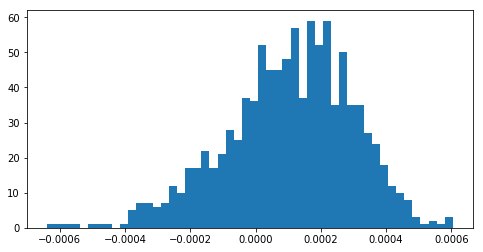

In [25]:
deltas = []
for _ in range(100):
    for train_ids, valid_ids in KFold(n_splits=10, shuffle=True).split(valid_pred.index):
        hack = valid_pred.iloc[valid_ids].copy()
        hack[hack['cloudy'] > .7] *= .7
        delta = (f2_score(train_flat.iloc[valid_ids], hack > threshold) -
                 f2_score(train_flat.iloc[valid_ids], valid_pred.iloc[valid_ids] > threshold))
        deltas.append(delta)
        # print('{:+.5f}'.format(delta))
plt.figure(figsize=(8, 4))
plt.hist(deltas, bins=50);
print('Mean delta {:+.5f}'.format(np.mean(deltas)))
print('T-test: {}'.format(ttest_1samp(deltas, 0)))

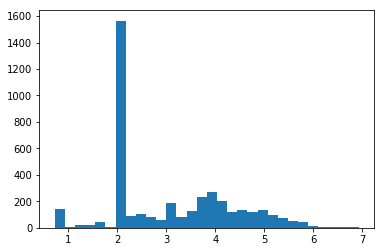

In [8]:
plt.hist(hack.as_matrix().sum(axis=1), bins=30);

In [11]:
bayes_valid = make_bayes_submission.get_df_prediction(valid_pred)

In [36]:
new_score = f2_score(train_flat, bayes_valid)
print('{:.6f}, {:.6f}'.format(new_score, new_score - original_score))

0.933267, 0.000057


In [37]:
new_score = f2_score(train_flat, make_bayes_submission.get_df_prediction(valid_pred, min_p=0.02, max_p=0.7))
print('{:.6f}, {:.6f}'.format(new_score, new_score - original_score))

0.933244, 0.000035


In [45]:
new_score = f2_score(train_flat, make_bayes_submission.get_df_prediction(valid_pred, min_p=0.03, max_p=0.5))
print('{:.6f}, {:.6f}'.format(new_score, new_score - original_score))

0.933270, 0.000061


Mean delta +0.000057
T-test: Ttest_1sampResult(statistic=6.1884754633871157, pvalue=8.8523569279878356e-10)


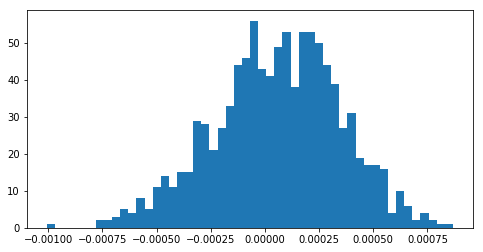

In [32]:
deltas = []
for _ in range(100):
    for train_ids, valid_ids in KFold(n_splits=10, shuffle=True).split(valid_pred.index):
        bayes = make_bayes_submission.get_df_prediction(valid_pred.iloc[valid_ids])
        delta = (f2_score(train_flat.iloc[valid_ids], bayes) -
                 f2_score(train_flat.iloc[valid_ids], valid_pred.iloc[valid_ids] > threshold))
        deltas.append(delta)
plt.figure(figsize=(8, 4))
plt.hist(deltas, bins=50);
print('Mean delta {:+.6f}'.format(np.mean(deltas)))
print('T-test: {}'.format(ttest_1samp(deltas, 0)))

Mean delta +0.000112
T-test: Ttest_1sampResult(statistic=3.3712499186743745, pvalue=0.0010683301814363732)


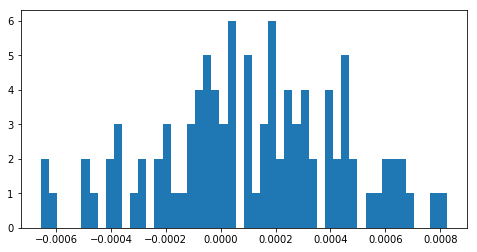

In [34]:
deltas = []
for _ in range(10):
    for train_ids, valid_ids in KFold(n_splits=10, shuffle=True).split(valid_pred.index):
        hack = valid_pred.iloc[valid_ids].copy()
        hack[hack['cloudy'] > .7] *= .7
        bayes = make_bayes_submission.get_df_prediction(hack)
        delta = (f2_score(train_flat.iloc[valid_ids], bayes) -
                 f2_score(train_flat.iloc[valid_ids], valid_pred.iloc[valid_ids] > threshold))
        deltas.append(delta)
plt.figure(figsize=(8, 4))
plt.hist(deltas, bins=50);
print('Mean delta {:+.6f}'.format(np.mean(deltas)))
print('T-test: {}'.format(ttest_1samp(deltas, 0)))